In [1]:
import torch as th

import time

import numpy as np
import matplotlib.pyplot as plt  
import seaborn as sns  
%matplotlib inline
sns.set()

In [46]:
dtype = th.float64

gpuid = 0
#device = th.device("cuda:"+ str(gpuid))
device = th.device("cpu")

print("Execution device: ",device)
print("PyTorch version: ", th.__version__ )
print("CUDA version: ", th.version.cuda)
print("CUDA device:", th.cuda.get_device_name(gpuid))

Execution device:  cpu
PyTorch version:  0.4.1
CUDA version:  9.0.176
CUDA device: TITAN V


In [47]:
# Utility functions

# batched vech2L input is "X" as V nb x n(n+1)/2
def bvech2L(V,nb,n):
    count = 0
    L = th.zeros((nb,n,n))
    for j in range(n):
        for i in range(j,n):
            L[...,i,j]=V[...,count]
            count = count + 1
    return th.tensor(L , device=device, dtype=dtype)

# Batched Cholesky decomp
def cholesky(A):
    L = th.zeros_like(A)
    
    for i in range(A.shape[-1]):
        for j in range(i+1):
            s = 0.0
            for k in range(j):
                s = s + L[...,i,k].clone() * L[...,j,k].clone()
            
            L[...,i,j] = th.sqrt(A[...,i,i] - s) if (i == j) else \
                      (1.0 / L[...,j,j].clone() * (A[...,i,j] - s))
    return L

# Batched inverse of lower triangular matrices 
def inverseL(L):
    n = L.shape[-1]
    invL = th.zeros_like(L)
    for j in range(0,n):
        invL[...,j,j] = 1.0/L[...,j,j]
        for i in range(j+1,n):
            S = 0.0
            for k in range(i+1):
                S = S - L[...,i,k]*invL[...,k,j].clone()
            invL[...,i,j] = S/L[...,i,i]

    return invL
            

In [4]:
n = 20  
m = 100*100
nn = int(n*(n+1)/2)

th.manual_seed(42)
X = th.rand((m,nn), device=device, dtype=dtype)+1.0
L = bvech2L(X,m,n)
A = th.matmul(L,th.transpose(L, 1, 2))
A.shape

torch.Size([10000, 20, 20])

In [48]:
def test_loop(n=4,m=1000):
    
    nn = int(n*(n+1)/2)
    
    th.manual_seed(42)
    X = th.rand((m,nn), device=device, dtype=dtype)
    L = th.add(bvech2L(X,m,n),th.tensor(th.eye(n)*2, device=device, dtype=dtype))
    A = th.matmul(L,th.transpose(L, 1, 2))
    #print("Shape of A {}".format(A.shape))
    
    start_time = time.time()

    cholA = th.zeros_like(A)
    for i in range(m):
        cholA[i,:,:] = th.potrf(A[i], upper=False) 
    
    runtime = time.time() - start_time
    #print("loop version took {:.6f} seconds ".format(runtime))
    return runtime

In [49]:
def test_batch(n=4,m=1000):
    
    nn = int(n*(n+1)/2)
    
    th.manual_seed(42)
    X = th.rand((m,nn), device=device, dtype=dtype)
    L = th.add(bvech2L(X,m,n), th.tensor(th.eye(n)*2, device=device, dtype=dtype))
    A = th.matmul(L,th.transpose(L, 1, 2))
    #print("Shape of A {}".format(A.shape))
    
    start_time = time.time()

    cholA = th.zeros_like(A)
    
    cholA = cholesky(A)
    
    runtime = time.time() - start_time
    #print("batched version took {:.6f} seconds ".format(runtime))
    return runtime

In [28]:
tval = test_loop(n=5,m=10000)

Shape of A torch.Size([10000, 5, 5])
loop version took 0.081758 seconds 


In [8]:
tval = test_batch(n=5,m=13000000)

Shape of A torch.Size([13000000, 5, 5])


RuntimeError: CUDA error: out of memory

In [10]:
CPU_times_loop = []
for t in range(1,101,10):
    CPU_times_loop.append(test_loop(n=10,m=100*t))


In [11]:
CPU_times_batch = []
for t in range(1,101,10):
    CPU_times_batch.append(test_batch(n=10,m=100*t))


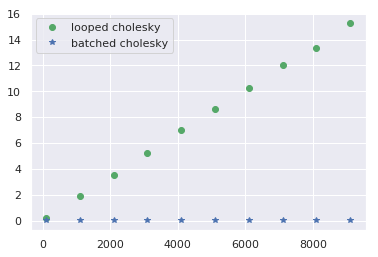

In [121]:
fig, ax = plt.subplots()

x = np.arange(1,101,10)*100
yl = times_loop
yb = times_batch
ax.plot( x,yl, "o", color='g', label='looped cholesky')  

ax.plot(x, yb , "*", label='batched cholesky')  
ax.legend()

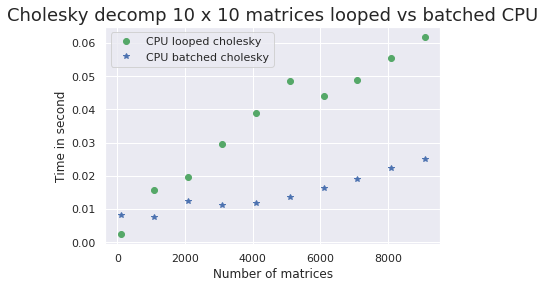

In [13]:
fig, ax = plt.subplots()

x = np.arange(1,101,10)*100
yl = CPU_times_loop
yb = CPU_times_batch
ax.plot( x,yl, "o", color='g', label='CPU looped cholesky')  

ax.plot(x, yb , "*", label='CPU batched cholesky') 

ax.set_ylabel('Time in second')
ax.set_xlabel('Number of matrices')
ax.set_title('Cholesky decomp 10 x 10 matrices looped vs batched CPU', fontsize=18)
ax.legend()

In [14]:
CPU_times_loop = []
for t in range(1,101,10):
    CPU_times_loop.append(test_loop(n=100,m=100*t))


In [16]:
CPU_times_batch = []
for t in range(1,101,10):
    CPU_times_batch.append(test_batch(n=100,m=100*t))


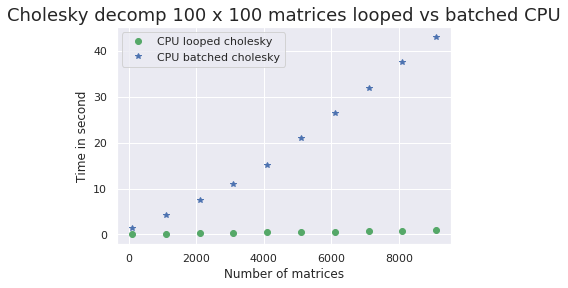

In [17]:
fig, ax = plt.subplots()

x = np.arange(1,101,10)*100
yl = CPU_times_loop
yb = CPU_times_batch
ax.plot( x,yl, "o", color='g', label='CPU looped cholesky')  

ax.plot(x, yb , "*", label='CPU batched cholesky') 

ax.set_ylabel('Time in second')
ax.set_xlabel('Number of matrices')
ax.set_title('Cholesky decomp 100 x 100 matrices looped vs batched CPU', fontsize=18)
ax.legend()

In [18]:
CPU_times_loop = []
for t in range(1,101,10):
    CPU_times_loop.append(test_loop(n=5,m=100*t))


In [19]:
CPU_times_batch = []
for t in range(1,101,10):
    CPU_times_batch.append(test_batch(n=5,m=100*t))


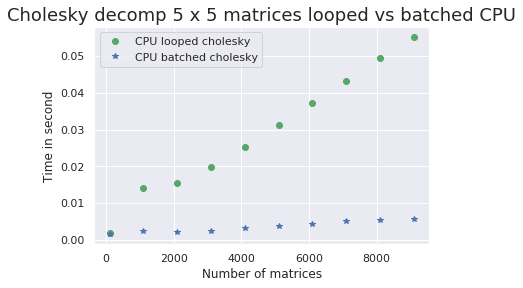

In [20]:
fig, ax = plt.subplots()

x = np.arange(1,101,10)*100
yl = CPU_times_loop
yb = CPU_times_batch
ax.plot( x,yl, "o", color='g', label='CPU looped cholesky')  

ax.plot(x, yb , "*", label='CPU batched cholesky') 

ax.set_ylabel('Time in second')
ax.set_xlabel('Number of matrices')
ax.set_title('Cholesky decomp 5 x 5 matrices looped vs batched CPU', fontsize=18)
ax.legend()

In [21]:
CPU_times_loop = []
for t in range(1,101,10):
    CPU_times_loop.append(test_loop(n=15,m=100*t))


In [22]:
CPU_times_batch = []
for t in range(1,101,10):
    CPU_times_batch.append(test_batch(n=15,m=100*t))


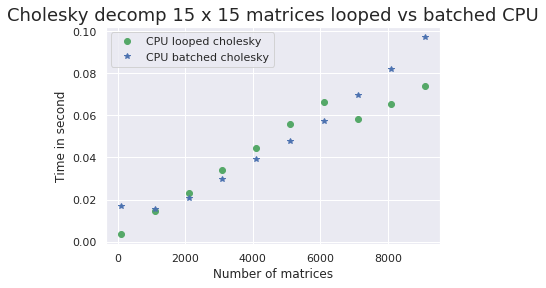

In [23]:
fig, ax = plt.subplots()

x = np.arange(1,101,10)*100
yl = CPU_times_loop
yb = CPU_times_batch
ax.plot( x,yl, "o", color='g', label='CPU looped cholesky')  

ax.plot(x, yb , "*", label='CPU batched cholesky') 

ax.set_ylabel('Time in second')
ax.set_xlabel('Number of matrices')
ax.set_title('Cholesky decomp 15 x 15 matrices looped vs batched CPU', fontsize=18)
ax.legend()

In [6]:
GPU_times_loop = []
for t in range(1,101,10):
    GPU_times_loop.append(test_loop(n=10,m=100*t))


In [7]:
GPU_times_batch = []
for t in range(1,101,10):
    GPU_times_batch.append(test_batch(n=10,m=100*t))


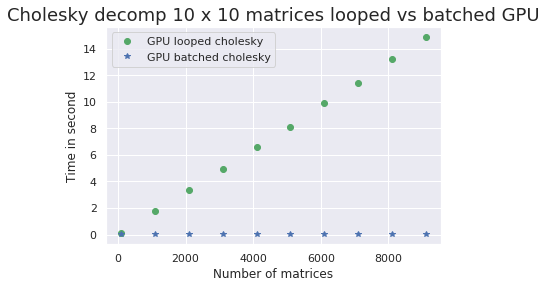

In [8]:
fig, ax = plt.subplots()

x = np.arange(1,101,10)*100
yl = GPU_times_loop
yb = GPU_times_batch
ax.plot( x,yl, "o", color='g', label='GPU looped cholesky')  

ax.plot(x, yb , "*", label='GPU batched cholesky') 

ax.set_ylabel('Time in second')
ax.set_xlabel('Number of matrices')
ax.set_title('Cholesky decomp 10 x 10 matrices looped vs batched GPU', fontsize=18)
ax.legend()

In [9]:
GPU_times_loop = []
for t in range(1,101,10):
    GPU_times_loop.append(test_loop(n=100,m=100*t))


In [10]:
GPU_times_batch = []
for t in range(1,101,10):
    GPU_times_batch.append(test_batch(n=100,m=100*t))


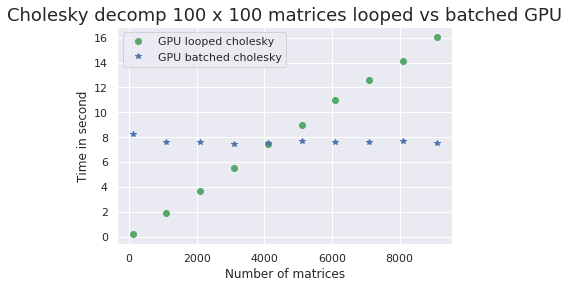

In [11]:
fig, ax = plt.subplots()

x = np.arange(1,101,10)*100
yl = GPU_times_loop
yb = GPU_times_batch
ax.plot( x,yl, "o", color='g', label='GPU looped cholesky')  

ax.plot(x, yb , "*", label='GPU batched cholesky') 

ax.set_ylabel('Time in second')
ax.set_xlabel('Number of matrices')
ax.set_title('Cholesky decomp 100 x 100 matrices looped vs batched GPU', fontsize=18)
ax.legend()

In [16]:
GPU_times_loop = []
for t in range(1,101,10):
    GPU_times_loop.append(test_loop(n=5,m=5*t))


In [17]:
GPU_times_batch = []
for t in range(1,101,10):
    GPU_times_batch.append(test_batch(n=5,m=100*t))


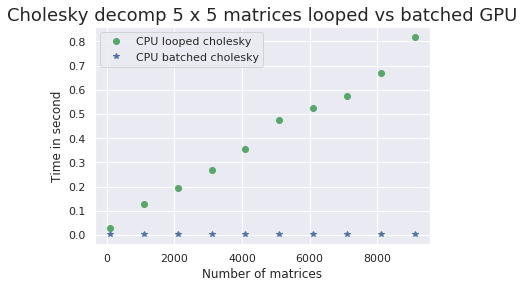

In [18]:
fig, ax = plt.subplots()

x = np.arange(1,101,10)*100
yl = GPU_times_loop
yb = GPU_times_batch
ax.plot( x,yl, "o", color='g', label='GPU looped cholesky')  

ax.plot(x, yb , "*", label='GPU batched cholesky') 

ax.set_ylabel('Time in second')
ax.set_xlabel('Number of matrices')
ax.set_title('Cholesky decomp 5 x 5 matrices looped vs batched GPU', fontsize=18)
ax.legend()

In [12]:
GPU_times_loop = []
for t in range(1,101,10):
    GPU_times_loop.append(test_loop(n=15,m=15*t))


In [13]:
GPU_times_batch = []
for t in range(1,101,10):
    GPU_times_batch.append(test_batch(n=5,m=100*t))


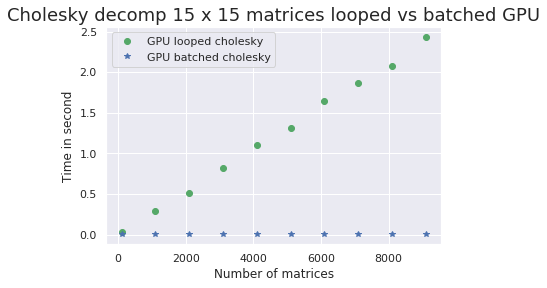

In [14]:
fig, ax = plt.subplots()

x = np.arange(1,101,10)*100
yl = GPU_times_loop
yb = GPU_times_batch
ax.plot( x,yl, "o", color='g', label='GPU looped cholesky')  

ax.plot(x, yb , "*", label='GPU batched cholesky') 

ax.set_ylabel('Time in second')
ax.set_xlabel('Number of matrices')
ax.set_title('Cholesky decomp 15 x 15 matrices looped vs batched GPU', fontsize=18)
ax.legend()

In [53]:
CPU_times_loop = []
for t in range(1,101,10):
    CPU_times_loop.append(test_loop(n=10,m=100*t))


In [54]:
CPU_times_batch = []
for t in range(1,101,10):
    CPU_times_batch.append(test_batch(n=10,m=100*t))


In [42]:
GPU_times_loop = []
for t in range(1,101,10):
    GPU_times_loop.append(test_loop(n=10,m=100*t))


In [48]:
GPU_times_batch = []
for t in range(1,101,10):
    GPU_times_batch.append(test_batch(n=10,m=100*t))


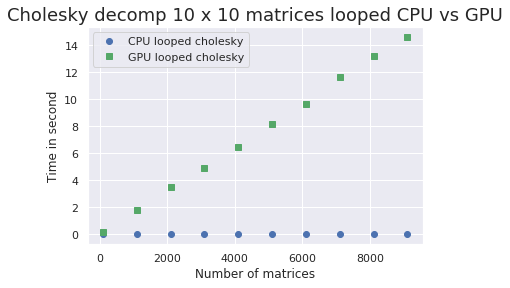

In [61]:
fig, ax = plt.subplots()

x = np.arange(1,101,10)*100
ylc = CPU_times_loop
ylg = GPU_times_loop
ax.plot( x,ylc, "o", color='b', label='CPU looped cholesky')  

ax.plot(x, ylg , "s", color='g', label='GPU looped cholesky') 

ax.set_ylabel('Time in second')
ax.set_xlabel('Number of matrices')
ax.set_title('Cholesky decomp 10 x 10 matrices looped CPU vs GPU', fontsize=18)
ax.legend()

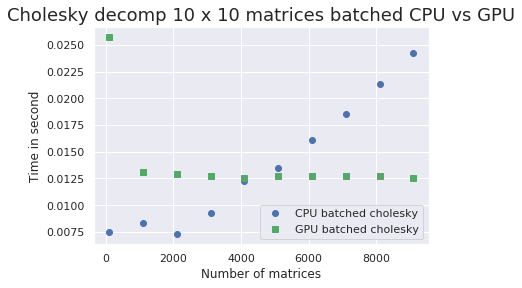

In [59]:
fig, ax = plt.subplots()

x = np.arange(1,101,10)*100
ylc = CPU_times_batch
ylg = GPU_times_batch
ax.plot( x,ylc, "o", color='b', label='CPU batched cholesky')  

ax.plot(x, ylg , "s", color='g', label='GPU batched cholesky') 

ax.set_ylabel('Time in second')
ax.set_xlabel('Number of matrices')
ax.set_title('Cholesky decomp 10 x 10 matrices batched CPU vs GPU', fontsize=18)
ax.legend()

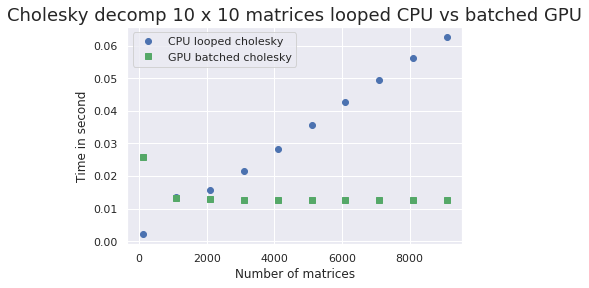

In [62]:
fig, ax = plt.subplots()

x = np.arange(1,101,10)*100
ylc = CPU_times_loop
ylg = GPU_times_batch
ax.plot( x,ylc, "o", color='b', label='CPU looped cholesky')  

ax.plot(x, ylg , "s", color='g', label='GPU batched cholesky') 

ax.set_ylabel('Time in second')
ax.set_xlabel('Number of matrices')
ax.set_title('Cholesky decomp 10 x 10 matrices looped CPU vs batched GPU', fontsize=18)
ax.legend()

In [35]:
GPU_times_batch = []
for t in range(500000,10000000,500000):
    GPU_times_batch.append(test_batch(n=5,m=t))

In [50]:
CPU_times_batch = []
for t in range(500000,10000000,500000):
    CPU_times_batch.append(test_batch(n=5,m=t))

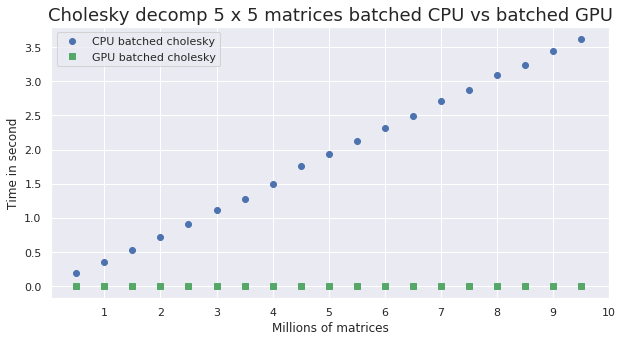

In [55]:
fig, ax = plt.subplots(figsize=(10,5))

#x = np.arange(10,10000000,500000)
x = np.arange(1,20)
ylc = CPU_times_batch
ylg = GPU_times_batch
ax.plot( x,ylc, "o", color='b', label='CPU batched cholesky')  

ax.plot(x, ylg , "s", color='g', label='GPU batched cholesky') 

ax.set_xticks([2,4,6,8,10,12,14,16,18,20])
ax.set_xticklabels(['1','2','3','4','5','6','7','8','9','10'])

ax.set_ylabel('Time in second')
ax.set_xlabel('Millions of matrices')
ax.set_title('Cholesky decomp 5 x 5 matrices batched CPU vs batched GPU', fontsize=18)
ax.legend()

In [54]:
CPU_times_loop = []
for t in range(500000,10000000,500000):
    CPU_times_loop.append(test_loop(n=5,m=t))

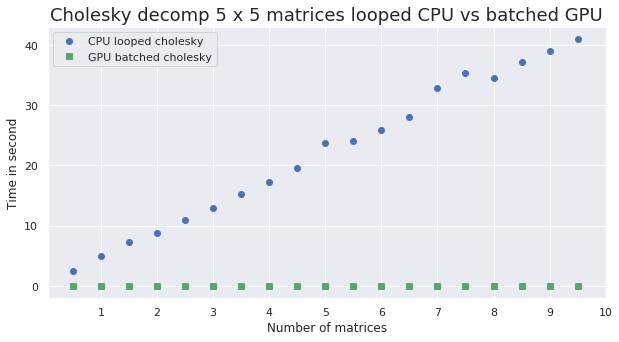

In [56]:
fig, ax = plt.subplots(figsize=(10,5))

#x = np.arange(10,10000000,500000)
x = np.arange(1,20)
ylc = CPU_times_loop
ylg = GPU_times_batch
ax.plot( x,ylc, "o", color='b', label='CPU looped cholesky')  

ax.plot(x, ylg , "s", color='g', label='GPU batched cholesky') 

ax.set_xticks([2,4,6,8,10,12,14,16,18,20])
ax.set_xticklabels(['1','2','3','4','5','6','7','8','9','10'])

ax.set_ylabel('Time in second')
ax.set_xlabel('Number of matrices')
ax.set_title('Cholesky decomp 5 x 5 matrices looped CPU vs batched GPU', fontsize=18)
ax.legend()

In [57]:
CPU_times_loop[-1]

41.00748872756958

In [58]:
GPU_times_batch[-1]

0.0018930435180664062

In [59]:
CPU_times_batch[-1]

3.621055841445923